In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import AttentionNetwork

import torch
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
import random
from tqdm.notebook import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from einops import einops

sns.set_style("darkgrid", {"grid.linestyle": ""})

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1

## Training section

### Generate train and test samples

In [3]:
maximum = []
maximum_targets = []
minimum = []
minimum_targets = []

for i in range(128):
    for j in range(128):
        maximum.append([(i, 128, j, 130)])
        maximum_targets.append(max(i,j))
        minimum.append([(i, 129, j, 130)])
        minimum_targets.append(min(i,j))

inputs = maximum + minimum
targets = maximum_targets + minimum_targets

pairs = list(zip(inputs, targets))
random.shuffle(pairs)

train, test = pairs[:len(pairs)//3], pairs[len(pairs)//3:]

X_train = torch.tensor([x[0] for x in train], device='cuda').squeeze()
y_train = torch.tensor([x[1] for x in train], device='cuda')

X_test = torch.tensor([x[0] for x in test],device='cuda').squeeze()
y_test = torch.tensor([x[1] for x in test],device='cuda')

### Initialize model

In [4]:
model = AttentionNetwork().to('cuda')
optim = torch.optim.AdamW(params=model.parameters(), lr=2e-3, weight_decay=1.0,betas=(0.9, 0.99))
criterion = nn.CrossEntropyLoss()

train_loss_records = []
acc_records = []

val_loss_records = []
val_acc_records = []

### Training Loop

In [5]:
for epoch in tqdm_notebook(range(0,750)):
    
    model.train()
    optim.zero_grad()
    
    pred, _ = model(X_train)
    pred = pred[:,-1,:]
    loss = criterion(pred, y_train)
    acc = (torch.sum(torch.argmax(pred, dim=-1)==y_train)/len(y_train)) * 100
    acc_records.append(acc.item())
    train_loss_records.append(loss.item())
    
    loss.backward()
    optim.step()
    
    model.eval()
    test_pred, _ = model(X_test)
    test_pred = test_pred[:,-1,:]
    val_loss = criterion(test_pred, y_test)
    val_acc = (torch.sum(torch.argmax(test_pred, dim=-1)==y_test)/len(y_test)) * 100
    val_acc_records.append(val_acc.item())
    val_loss_records.append(loss.item())

  0%|          | 0/750 [00:00<?, ?it/s]

### Plot accuracy curves

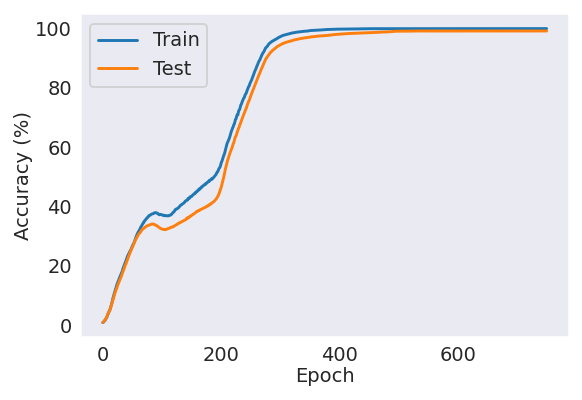

In [6]:
plt.figure(dpi=140, figsize=(4.5,3))
plt.plot(acc_records[:], label='Train')
plt.plot(val_acc_records[:], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

### Save the model

In [7]:
torch.save(model.state_dict(), 'model_weights.pt')

## Visualize attention heads

### Load the trained model

In [8]:
model = AttentionNetwork()
model.to('cuda')
model.load_state_dict(torch.load('model_weights.pt', weights_only=True))

<All keys matched successfully>

### Run inference on max() task for all possible inputs

In [9]:
inp_x = torch.tensor([(a, 128, b, 130) for a in range(128) for b in range(128)], device='cuda')
_, activations = model(inp_x)
att_weights = activations['attention_pattern']
att_scores = activations['attention_scores']
att_weights = einops.rearrange(att_weights,"(i j) heads q_pos k_pos -> heads q_pos k_pos i j", i=128, j=128)[:,-1,:-1,:,:]
att_scores = einops.rearrange(att_scores,"(i j) heads q_pos k_pos -> heads q_pos k_pos i j", i=128, j=128)[:,-1,:-1,:,:]

### Plot attention weights and scores

C:\Users\91967\AppData\Local\Temp\ipykernel_21020\812013540.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


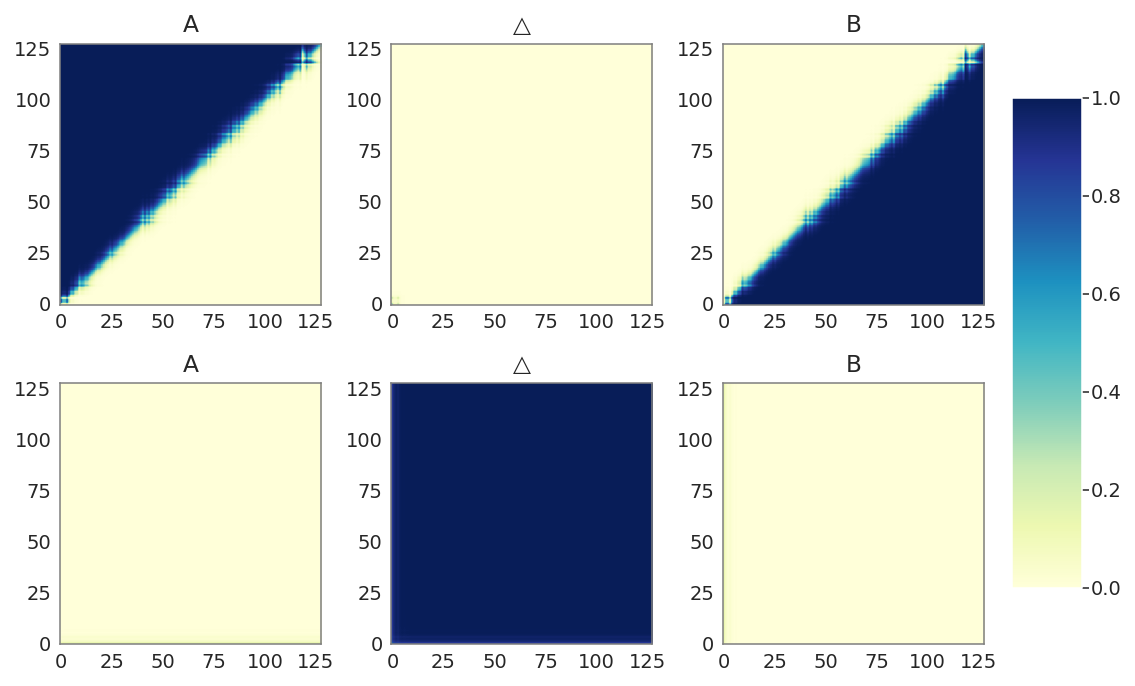

In [10]:
fig_title = ['A', '△', 'B' , '=']
fig, ax = plt.subplots(2,3, figsize=(10,5), dpi=140)
for h, arr in enumerate(att_weights):
    for k, att_pat in enumerate(arr):
        im = ax[h,k].imshow(att_pat, cmap='YlGnBu', origin='lower', vmin=0, vmax=1)
        ax[h,k].set_title((fig_title[k]))
        ax[h,k].spines['left'].set_color('grey')
        ax[h,k].spines['right'].set_color('grey')
        ax[h,k].spines['top'].set_color('grey')
        ax[h,k].spines['bottom'].set_color('grey')
        ax[h,k].set_xticks(list(range(0, 128, 25)))


fig.subplots_adjust(right=1.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()

C:\Users\91967\AppData\Local\Temp\ipykernel_21020\1137641182.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


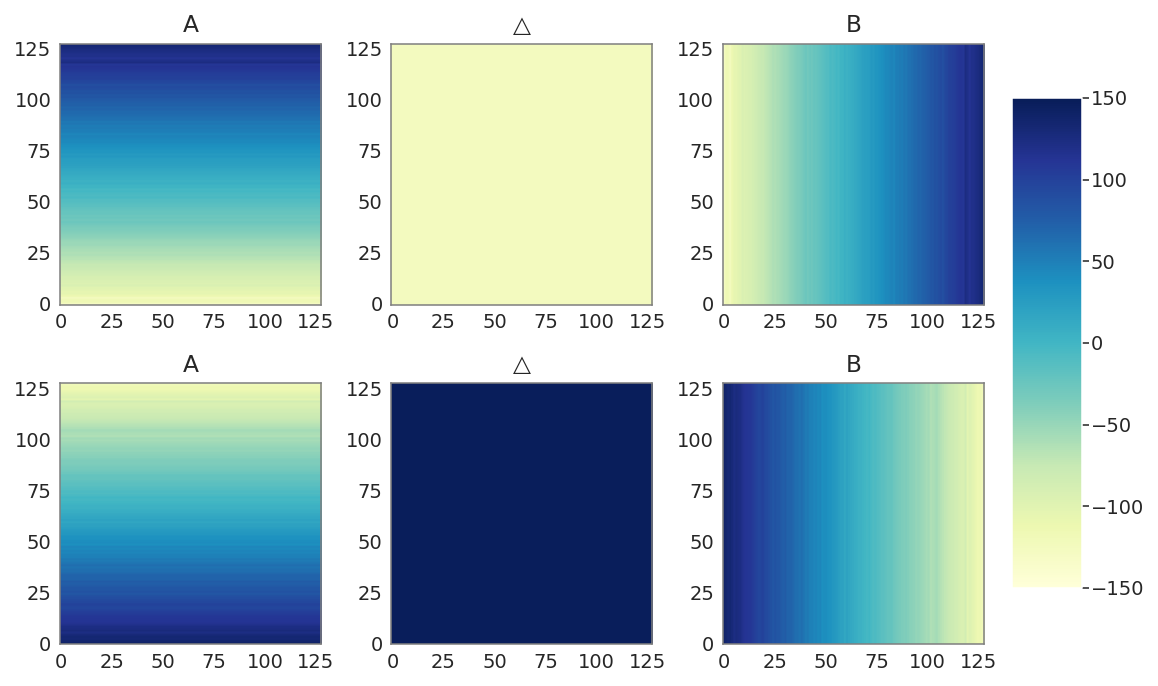

In [11]:
fig_title = ['A', '△', 'B' , '=']
fig, ax = plt.subplots(2,3, figsize=(10,5), dpi=140)
for h, arr in enumerate(att_scores):
    for k, att_pat in enumerate(arr):
        im = ax[h,k].imshow(att_pat, cmap='YlGnBu', origin='lower', vmin=-150, vmax=150)
        ax[h,k].set_title((fig_title[k]))
        ax[h,k].spines['left'].set_color('grey')
        ax[h,k].spines['right'].set_color('grey')
        ax[h,k].spines['top'].set_color('grey')
        ax[h,k].spines['bottom'].set_color('grey')
        ax[h,k].set_xticks(list(range(0, 128, 25)))


fig.subplots_adjust(right=1.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()

### Run inference on min() task for all possible inputs

In [12]:
inp_x = torch.tensor([(a, 129, b, 130) for a in range(128) for b in range(128)], device='cuda')
_, activations = model(inp_x)
att_weights = activations['attention_pattern']
att_scores = activations['attention_scores']
att_weights = einops.rearrange(att_weights,"(i j) heads q_pos k_pos -> heads q_pos k_pos i j", i=128, j=128)[:,-1,:-1,:,:]
att_scores = einops.rearrange(att_scores,"(i j) heads q_pos k_pos -> heads q_pos k_pos i j", i=128, j=128)[:,-1,:-1,:,:]

### Plot attention weights and scores

C:\Users\91967\AppData\Local\Temp\ipykernel_21020\1907703000.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


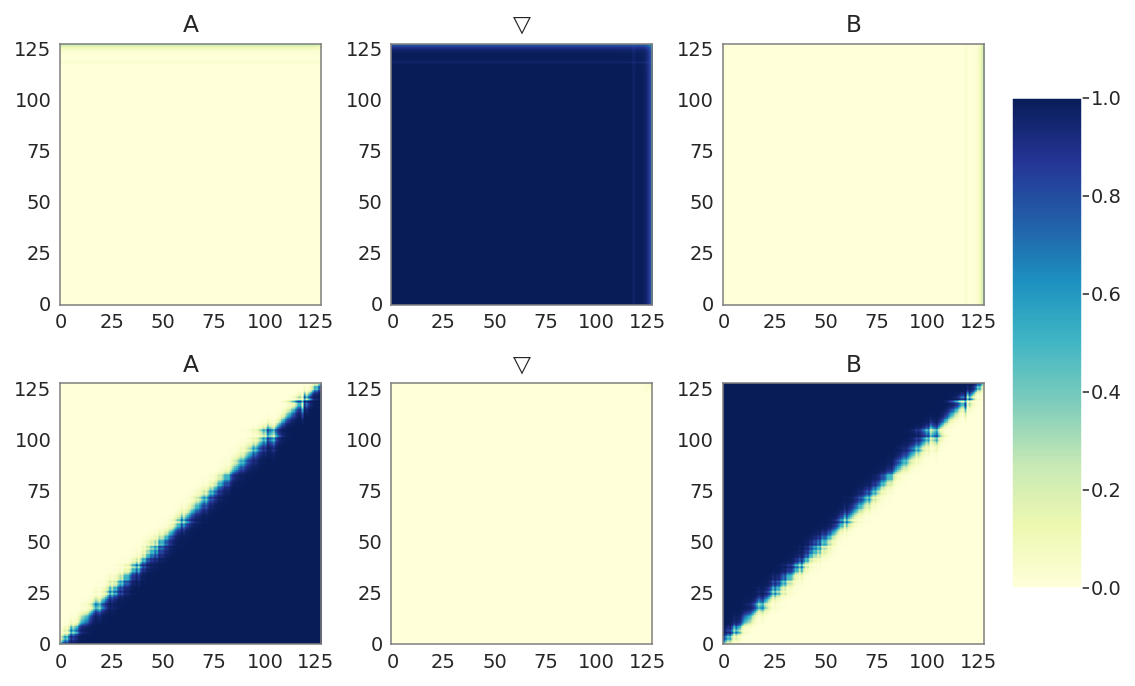

In [13]:

fig_title = ['A', '▽', 'B' , '=']
fig, ax = plt.subplots(2,3, figsize=(10,5), dpi=140)
for h, arr in enumerate(att_weights):
    for k, att_pat in enumerate(arr):
        im = ax[h,k].imshow(att_pat, cmap='YlGnBu', origin='lower', vmin=0, vmax=1)
        ax[h,k].set_title((fig_title[k]))
        ax[h,k].spines['left'].set_color('grey')
        ax[h,k].spines['right'].set_color('grey')
        ax[h,k].spines['top'].set_color('grey')
        ax[h,k].spines['bottom'].set_color('grey')
        ax[h,k].set_xticks(list(range(0, 128, 25)))


fig.subplots_adjust(right=1.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()

C:\Users\91967\AppData\Local\Temp\ipykernel_21020\4167560049.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


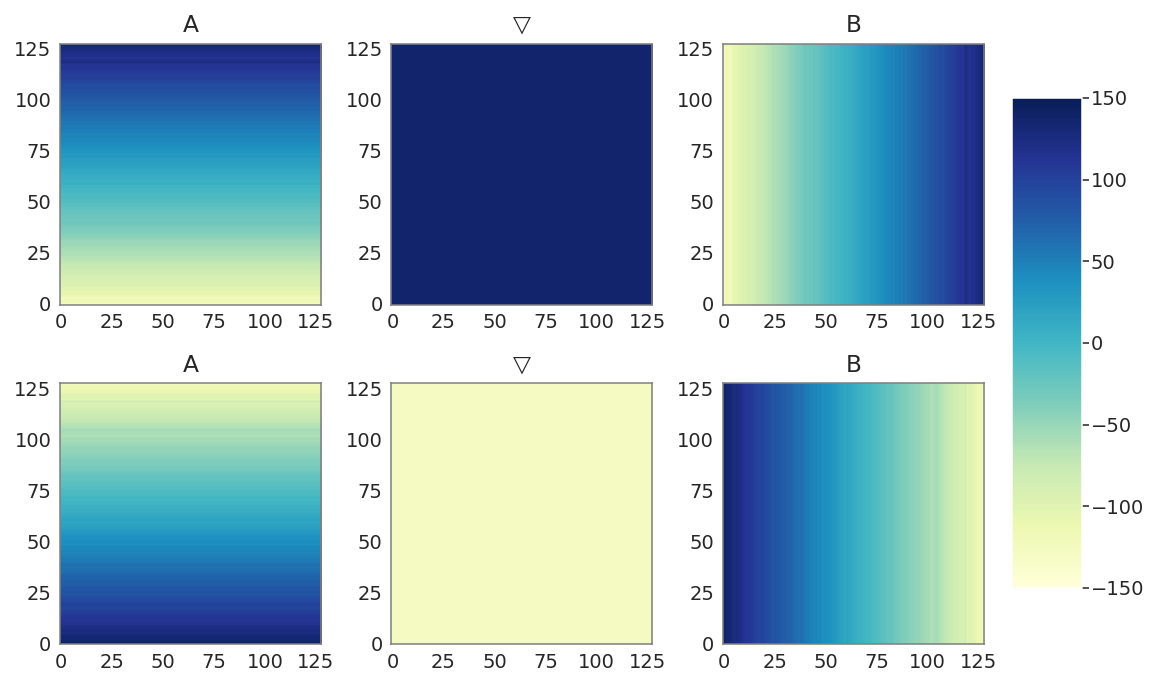

In [14]:
fig_title = ['A', '▽', 'B' , '=']
fig, ax = plt.subplots(2,3, figsize=(10,5), dpi=140)
for h, arr in enumerate(att_scores):
    for k, att_pat in enumerate(arr):
        im = ax[h,k].imshow(att_pat, cmap='YlGnBu', origin='lower', vmin=-150, vmax=150)
        ax[h,k].set_title((fig_title[k]))
        ax[h,k].spines['left'].set_color('grey')
        ax[h,k].spines['right'].set_color('grey')
        ax[h,k].spines['top'].set_color('grey')
        ax[h,k].spines['bottom'].set_color('grey')
        ax[h,k].set_xticks(list(range(0, 128, 25)))


fig.subplots_adjust(right=1.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()